<a href="https://colab.research.google.com/github/pchlenski/misdeed/blob/main/notebooks/paper_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Expanded imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as p

# google colab specific stuff
from google.colab import drive
drive.mount('/content/drive')

# set environmental variables
dd = '/content/drive/My Drive/notebooks/melody/data/' # data directory

# pandas settings
%load_ext google.colab.data_table

# fonts
import matplotlib as mpl
# mpl.font_manager.fontManager.addfont('/content/drive/My Drive/fonts/Gill Sans.otf')
mpl.font_manager.fontManager.addfont('/content/drive/My Drive/fonts/Helvetica.ttf')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
font = {
    'family' : 'Helvetica', 
    'size' : 20
}
mpl.rc('font', **font)

# colors - consistent with google slides 'basic light' defaults
red = '#be1e2d'
blue = '#0097a7'
yellow = '#ffab40'

# other settings
mpl.rcParams['figure.dpi'] = 350
mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['figure.frameon'] = False
mpl.rcParams['image.cmap'] = 'magma'
mpl.rcParams['patch.facecolor'] = '#00000000'
mpl.rcParams['legend.framealpha'] = 0
mpl.rcParams['axes.facecolor'] = '#fffff800'
mpl.rcParams['axes.linewidth'] = 2

# turn off spines
# mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
# mpl.rcParams['axes.spines.left'] = False

In [ ]:
# !git clone https://github.com/pchlenski/misdeed
# !cd /content/misdeed && git pull
!pip install misdeed

from misdeed.OmicsGenerator import OmicsGenerator
from misdeed.visualization import plot_timecourse, plot_pca

In [ ]:
# All settings
N_TIME_POINTS = 400
N_MGX = 12
N_MBX = 6
np.random.seed(20) # for reproducibility

# Intervention settings
EFFECT_SIZE = 20

# Random matrix settings
C = 0.5
D = 5
SIGMA = 1

# Generator settings
DT = 1e-2
N_READS = 500
DOWNSAMPLE = 5

gen = OmicsGenerator(
    time_points=N_TIME_POINTS,
    node_names=['mgx', 'mbx'],
    node_sizes=[N_MGX, N_MBX],
    init_full=True,
    C=C,
    d=D,
    sigma=SIGMA,
)

# want sigma * sqrt(C * (n_mgx + m_mbx)) < d

gen.add_intervention(
    name='int1',
    node_name='mbx',
    vector=EFFECT_SIZE * np.random.rand(N_MBX),
    affects_abundance=True,
    start=100,
    end=N_TIME_POINTS
)
gen.get('mbx').growth_rates = np.zeros(N_MBX) # no growth rates for mbx
gen.get('mbx->mgx').matrix *= .2
gen.get('mgx->mbx').matrix *= .2  # Reduce magnitude of cross-node interactions

Node 'mgx' initialized
Node 'mbx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:12    0:12
Interaction 'mgx->mbx' added
set m:(mgx)->(mbx):   0:12    12:18
Interaction 'mbx->mgx' added
set m:(mbx)->(mgx):   12:18    0:12
Interaction 'mbx->mbx' added
set m:(mbx)->(mbx):   12:18    12:18
Added x0 vector to node mgx
Added growth rates to node mgx
Added x0 vector to node mbx
Added growth rates to node mbx
Initialized
Intervention 'int1' added


Text(0.5, 0.98, 'Interventions to metabolite abundances affect metagenomic dynamics')

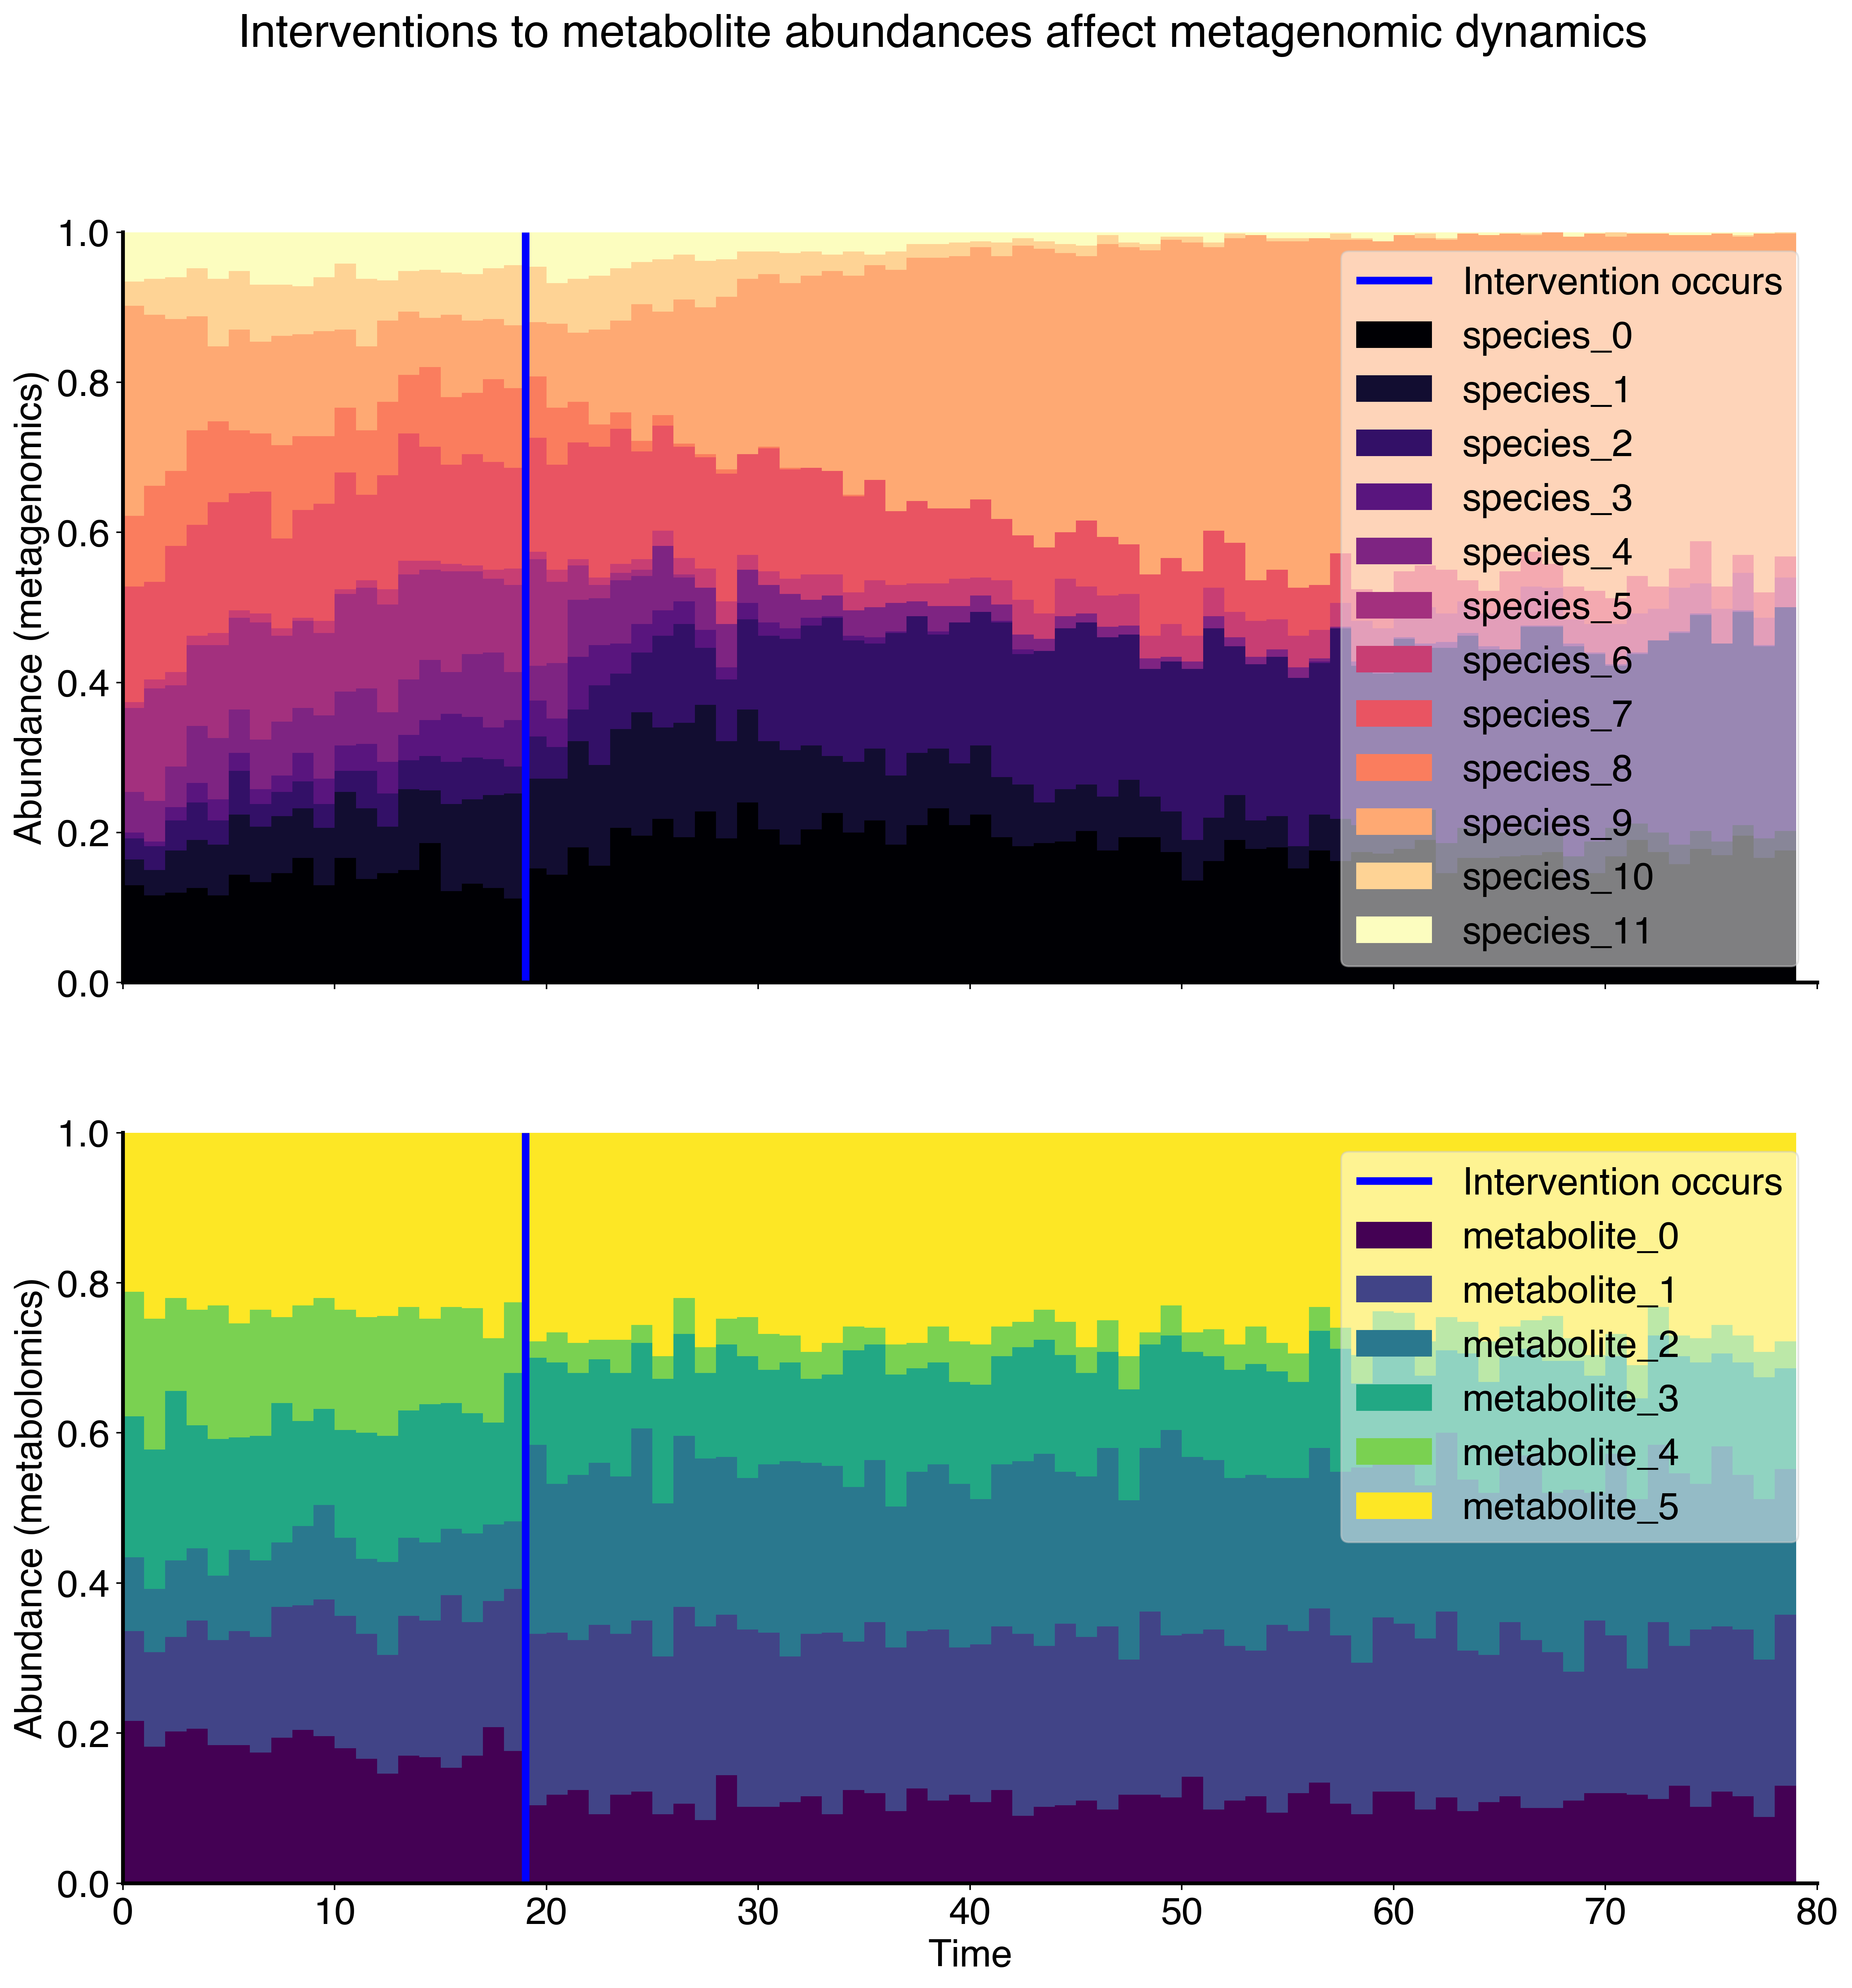

In [ ]:
x,y,z = gen.generate(
    dt=DT,
    n_reads=N_READS,
    downsample=DOWNSAMPLE
)

colors_mgx = mpl.cm.get_cmap('magma', N_MGX)
colors_mgx = colors_mgx(range(N_MGX))
colors_mbx = mpl.cm.get_cmap('viridis', N_MBX)
colors_mbx = colors_mbx(range(N_MBX))

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(16,16))
to_plot = np.cumsum(z['mgx'], axis=1)
axs[0].vlines(19,0,1,colors='blue',lw=4, label="Intervention occurs") # This is the intervention indicator
for i in range(N_MGX):
    if i > 0:
        start = to_plot[:,i-1]
    else:
        start = 0
    axs[0].fill_between(range(len(to_plot)), start, to_plot[:,i], color=colors_mgx[i], lw=0, step='post')
axs[0].set_xlim(0,80)
axs[0].set_ylim(0,1)
axs[0].set_ylabel('Abundance (metagenomics)')
axs[0].legend(
    labels=["Intervention occurs", *[f"species_{i}" for i in range(N_MGX + 1)]],
    facecolor='white', 
    framealpha=0.5
)

to_plot = np.cumsum(z['mbx'], axis=1)
axs[1].vlines(19,0,1,colors='blue',lw=4)
for i in range(N_MBX):
    if i > 0:
        start = to_plot[:,i-1]
    else:
        start = 0
    axs[1].fill_between(range(len(to_plot)), start, to_plot[:,i], color=colors_mbx[i], lw=0, step='pre')
axs[1].set_xlim(0,80)
axs[1].set_ylim(0,1)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Abundance (metabolomics)')
axs[1].legend(
    labels=["Intervention occurs", *[f"metabolite_{i}" for i in range(N_MBX + 1)]], 
    facecolor='white', 
    framealpha=0.5
)

fig.suptitle("Interventions to metabolite abundances affect metagenomic dynamics")

Removed intervention 'int1'
Intervention 'CASE' added


Text(0.5, 1.0, 'Interventions induce change of direction in PCA')

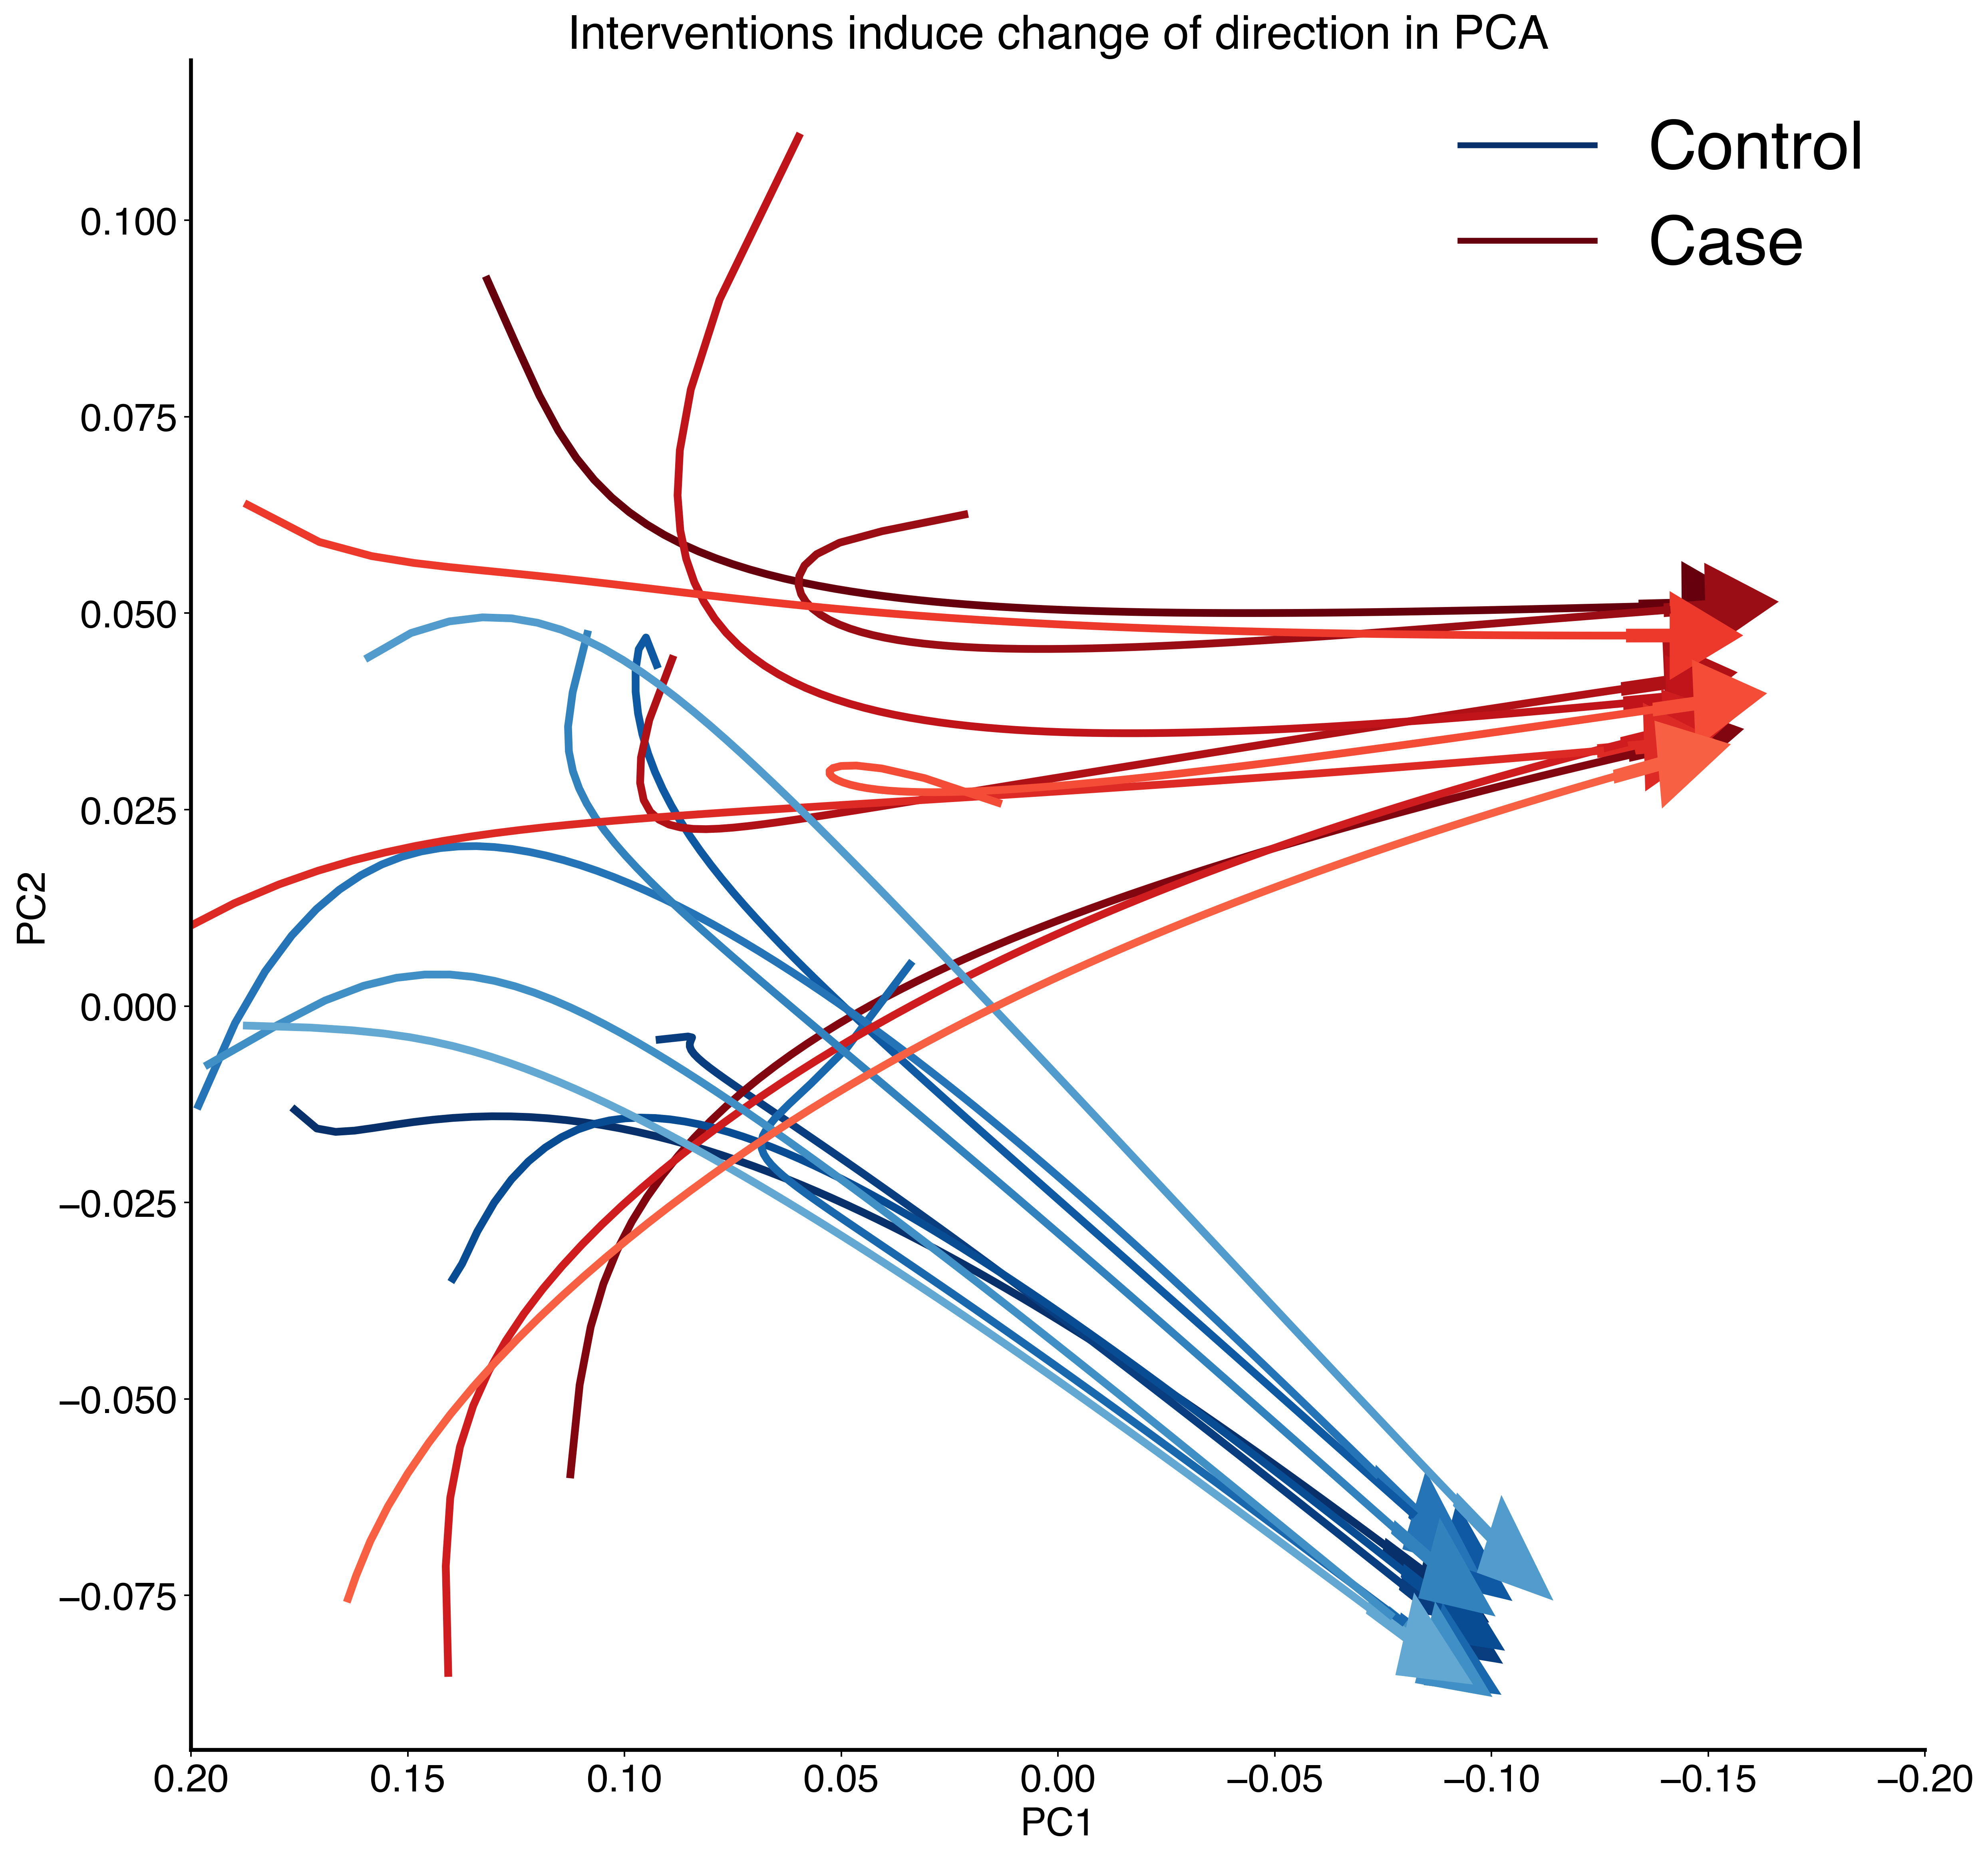

In [ ]:
# params for PCA plot
N_PARTICIPANTS = 20
CASE_FRAC = 0.5
NOISE_VAR = 0 # not realistic but gives us smooth trajectories

try:
    gen.remove('int1')
except Exception:
    pass

z2,x2,y2,z3,x3,y3 = gen.case_control(
    participants=N_PARTICIPANTS,
    case_frac=CASE_FRAC,
    node_name='mbx',
    effect_size=EFFECT_SIZE,
    dt=DT,
    noise_var=NOISE_VAR,
    n_reads=N_READS,
    downsample=DOWNSAMPLE
)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

data1 = np.array([sample['mgx'] for sample in x2])
data1 = data1.reshape(-1, N_MGX)
data2 = np.array([sample['mgx'] for sample in x3])
data2 = data2.reshape(-1, N_MGX)
data = np.concatenate((data1, data2), axis=0)

pca.fit(data)

colors1 = mpl.cm.get_cmap('Blues_r', N_PARTICIPANTS)
colors1 = colors1(range(N_PARTICIPANTS))

colors2 = mpl.cm.get_cmap('Reds_r', N_PARTICIPANTS)
colors2 = colors2(range(N_PARTICIPANTS))

plt.figure(figsize=(16,16))
for i in range(int(N_PARTICIPANTS / 2)):
    course1 = x2[i]
    to_plot1 = pca.transform(course1['mgx'])
    plt.plot(
        to_plot1[:-4,0], 
        to_plot1[:-4,1], 
        c=colors1[i],
        lw=4
    )
    course2 = x3[i]
    to_plot2 = pca.transform(course2['mgx'])
    plt.plot(
        to_plot2[:-4,0],
        to_plot2[:-4,1],
        c=colors2[i],
        lw=4
    )
    plt.arrow(
        to_plot1[-5,0], to_plot1[-5,1], 
        to_plot1[-1,0] - to_plot1[-5,0], to_plot1[-1,1] - to_plot1[-5,1],
        color=colors1[i],
        shape='full',
        lw=3,
        head_width=.01
    )
    plt.arrow(
        to_plot2[-5,0], to_plot2[-5,1], 
        to_plot2[-1,0] - to_plot2[-5,0], to_plot2[-1,1] - to_plot2[-5,1],
        color=colors2[i],
        shape='full',
        lw=3,
        head_width=.01
    )
plt.xlim(0.2, -0.2) # flip x axes for intuitive directions
# plt.ylim(-2, 5)
plt.xlabel('PC1')
plt.ylabel('PC2')

# fake lines
l = [
     plt.Line2D([0], [0], color=colors1[0], linewidth=3),
     plt.Line2D([0], [0], color=colors2[0], linewidth=3)
]
plt.legend(l, ["Control", "Case"], fontsize='xx-large')
plt.title("Interventions induce change of direction in PCA")
